# *PYSPARK DATAFRAMES FROM CSVs*

In [1]:
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import *

21/08/20 08:15:25 WARN Utils: Your hostname, ubuntu-Lenovo-V330-14IKB resolves to a loopback address: 127.0.0.1; using 192.168.0.106 instead (on interface wlp2s0)
21/08/20 08:15:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/20 08:15:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Loadind csv file and creating dataframe

In [2]:
Df= spark.read.format("csv").option("header","true").load("hdfs://localhost:9000/Spark/CpuLogData/*.csv")

In [3]:
Df.printSchema()

root
 |-- DateTime: string (nullable = true)
 |-- Cpu Count: string (nullable = true)
 |-- Cpu Working Time: string (nullable = true)
 |-- Cpu idle Time: string (nullable = true)
 |-- cpu_percent: string (nullable = true)
 |-- Usage Cpu Count : string (nullable = true)
 |-- number of software interrupts since boot: string (nullable = true)
 |-- number of system calls since boot: string (nullable = true)
 |-- number of interrupts since boot: string (nullable = true)
 |-- cpu avg load over 1 min: string (nullable = true)
 |-- cpu avg load over 5 min: string (nullable = true)
 |-- cpu avg load over 15 min: string (nullable = true)
 |-- system_total_memory: string (nullable = true)
 |-- system_used_memory: string (nullable = true)
 |-- system_free_memory: string (nullable = true)
 |-- system_active_memory: string (nullable = true)
 |-- system_inactive_memory: string (nullable = true)
 |-- system_buffers_memory: string (nullable = true)
 |-- system_cached_memory: string (nullable = true)
 |

## counting total entries in dataframe

In [4]:
Df.count()

4122

In [5]:
Df.select("user_name","DateTime","boot_time","keyboard","mouse").show()

+--------------------+-------------------+--------------+--------+------+
|           user_name|           DateTime|     boot_time|keyboard| mouse|
+--------------------+-------------------+--------------+--------+------+
|  iamnzm@outlook.com|2019-09-19 08:40:02|0:09:59.262105|     1.0|  32.0|
|  iamnzm@outlook.com|2019-09-19 08:45:02|0:14:59.259253|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:50:01|0:19:58.817858|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:55:01|0:24:58.366251|    11.0| 900.0|
|  iamnzm@outlook.com|2019-09-19 09:00:01|0:29:59.008276|     2.0|  25.0|
|  iamnzm@outlook.com|2019-09-19 09:05:01|0:34:58.858791|    37.0| 336.0|
|deepshukla292@gma...|2019-09-19 09:05:01|0:05:19.424878|     0.0|  55.0|
|  iamnzm@outlook.com|2019-09-19 09:10:01|0:39:58.482956|     0.0| 136.0|
|deepshukla292@gma...|2019-09-19 09:10:01|0:10:19.516467|     6.0|1112.0|
|  iamnzm@outlook.com|2019-09-19 09:15:02|0:44:59.088574|     0.0|  84.0|
|deepshukla292@gma...|2019-09-19 09:15

## Creating temp view to perform sql quieries

In [6]:
Df.createOrReplaceTempView("log_data")

21/08/20 08:16:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Query to fetch total entries for each person

In [7]:
avg_hr_df= spark.sql("select user_name ,count('') as total from log_data where keyboard !=0.0 or mouse!=0.0 group by user_name")

In [8]:
avg_hr_df.show()

+--------------------+-----+
|           user_name|total|
+--------------------+-----+
|salinabodale73@gm...|  440|
|sharlawar77@gmail...|  457|
|rahilstar11@gmail...|  399|
|deepshukla292@gma...|  475|
|  iamnzm@outlook.com|  459|
|markfernandes66@g...|  389|
|damodharn21@gmail...|  191|
|bhagyashrichalke2...|  361|
+--------------------+-----+



## Creating tenp view

In [9]:
avg_hr_df.createOrReplaceTempView("avg_hr")

## Query to get avg seconds of work for each person

In [10]:
hrs_df=spark.sql("select user_name, ((((total-1)*5)*60)/6) as avg_hrs from avg_hr")

In [11]:
hrs_df.show()

+--------------------+-------+
|           user_name|avg_hrs|
+--------------------+-------+
|salinabodale73@gm...|21950.0|
|sharlawar77@gmail...|22800.0|
|rahilstar11@gmail...|19900.0|
|deepshukla292@gma...|23700.0|
|  iamnzm@outlook.com|22900.0|
|markfernandes66@g...|19400.0|
|damodharn21@gmail...| 9500.0|
|bhagyashrichalke2...|18000.0|
+--------------------+-------+



## Converting seconds into hrs and min and showing max avg hrs

In [12]:
final_avg_hr=hrs_df.withColumn("Minutes", round((col("avg_hrs")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("Time", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("hr "),col("hourmin"),lit("min"))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2","avg_hrs")\
.sort(desc("Time")).show()

+--------------------+---------+
|           user_name|     Time|
+--------------------+---------+
|salinabodale73@gm...| 6hr 5min|
|deepshukla292@gma...|6hr 35min|
|  iamnzm@outlook.com|6hr 21min|
|sharlawar77@gmail...|6hr 20min|
|rahilstar11@gmail...|5hr 31min|
|markfernandes66@g...|5hr 23min|
|bhagyashrichalke2...| 5hr 0min|
|damodharn21@gmail...|2hr 38min|
+--------------------+---------+



## TO get min avg hrs

In [13]:
final_avg_hr=hrs_df.withColumn("Minutes", round((col("avg_hrs")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("Time", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("hr "),col("hourmin"),lit("min"))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2","avg_hrs")\
.sort(asc("Time")).show()

+--------------------+---------+
|           user_name|     Time|
+--------------------+---------+
|damodharn21@gmail...|2hr 38min|
|bhagyashrichalke2...| 5hr 0min|
|markfernandes66@g...|5hr 23min|
|rahilstar11@gmail...|5hr 31min|
|sharlawar77@gmail...|6hr 20min|
|  iamnzm@outlook.com|6hr 21min|
|deepshukla292@gma...|6hr 35min|
|salinabodale73@gm...| 6hr 5min|
+--------------------+---------+



# Counting idle hours

## Taking entries when mouse and keyboard entries are 0

In [14]:
idle_count = spark.sql("select user_name, DateTime from log_data where keyboard=0 and mouse=0").groupBy("user_name").count()

## counting total idle hour entries

In [15]:
idle_count.sort('count').show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|damodharn21@gmail...|   62|
|deepshukla292@gma...|   90|
|markfernandes66@g...|  119|
|bhagyashrichalke2...|  121|
|sharlawar77@gmail...|  123|
|salinabodale73@gm...|  133|
|rahilstar11@gmail...|  152|
|  iamnzm@outlook.com|  155|
+--------------------+-----+



## Creating a temp view

In [16]:
idle_count.createOrReplaceTempView("idle_time")

## Counting avg seconds for idle hrs

In [17]:
idle_df=spark.sql("select user_name, (((count-1)*5*60)/6) as idle_min from idle_time")

## converting seconds into hr and mins

In [18]:
idle_hrs=idle_df.withColumn("Minutes", round((col("idle_min")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("Idle_Hrs", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("hr "),col("hourmin"),lit("min"))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2",'idle_min')\
.sort(asc("Idle_Hrs")).show()

+--------------------+---------+
|           user_name| Idle_Hrs|
+--------------------+---------+
|deepshukla292@gma...|1hr 14min|
|markfernandes66@g...|1hr 38min|
|bhagyashrichalke2...|1hr 40min|
|sharlawar77@gmail...|1hr 41min|
|salinabodale73@gm...|1hr 50min|
|rahilstar11@gmail...| 2hr 5min|
|  iamnzm@outlook.com| 2hr 8min|
|damodharn21@gmail...|    50min|
+--------------------+---------+



# VISUALIZATION WITH MATPLOTLIB

## Importing matplotlib

In [19]:
import matplotlib.pyplot as plt
import pandas

## creating pandas dataframe from our dataframe

In [20]:
idle = idle_count.toPandas()

In [21]:
username= idle['user_name']
hrs=idle['count']

In [22]:
colors =['Red', 'Blue', 'Green','Grey','Brown','Red','Blue','Black']
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)

## Plotting on a pie chart for idle hrs

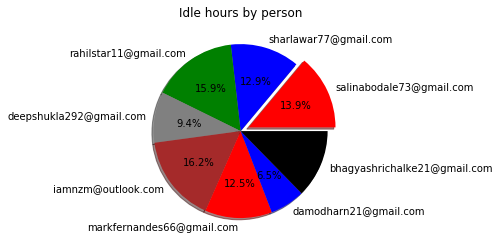

In [23]:

plt.pie(hrs, labels=username, explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True)
plt.title("Idle hours by person")
plt.show()

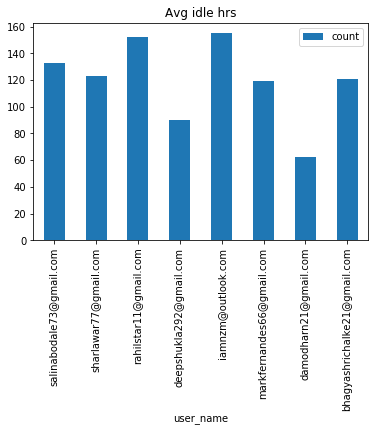

In [29]:
idle.plot.bar(x='user_name',y='count',title='Avg idle hrs')
plt.show()

In [30]:
idle_sec=idle_df.toPandas()

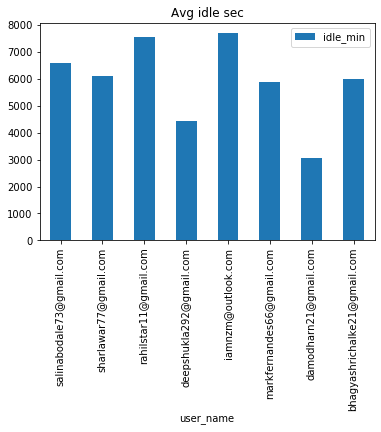

In [34]:
idle_sec.plot.bar(x='user_name',y='idle_min',title='Avg idle sec')
plt.show()

## Pie chart for Avg Hrs

In [ ]:
avg_HR = hrs_df.toPandas()

In [ ]:
username= avg_HR['user_name']
hrs=avg_HR['avg_hrs']

In [ ]:
colors =['Red', 'Blue', 'Green','Grey','Brown','Red','Blue','Black']
explode = (0.1, 0, 0, 0, 0, 0,0,0)

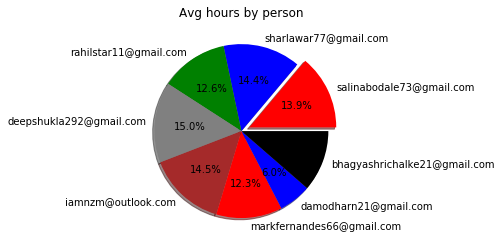

In [ ]:
plt.pie(hrs, labels=username, explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True)
plt.title("Avg hours by person")
plt.show()

In [35]:
avg_HR.plot.bar(x='user_name',y='avg_hrs',title='Avg work time')
plt.show()

NameError: name 'avg_HR' is not defined